In [1]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FixedLocator
import matplotlib.patches as mpatches
import numpy as np

# from sklearn import cluster, datasets, mixture
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.exceptions import ConvergenceWarning

from collections import Counter

import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns


In [ ]:
import AutoGMM, KernelAutoGMM

In [3]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter, pandas2ri
from rpy2.robjects.vectors import IntVector, StrVector

# Activate pandas ↔ R conversion
pandas2ri.activate()

# Load mclust
mclust = importr("mclust")

# Pre‑create the default modelNames vector
MODELNAMES_VVV = StrVector(["VVV", "EEE", "VVI", "VII"])

def run_mclust(
    X: pd.DataFrame,
    constrain_cov: bool = True,
    n_components: int | list[int] | range | None = None,
    y_true: np.ndarray | None = None,
):

    # ensure DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # convert to R data.frame
    with localconverter(default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(X)

    # build kwargs for Mclust
    kwargs: dict[str, ro.Vector] = {}
    if constrain_cov:
        kwargs["modelNames"] = MODELNAMES_VVV
    # handle n_components
    if n_components is not None:
        if isinstance(n_components, (list, range, np.ndarray)):
            # convert each to int
            G = [int(g) for g in n_components]
        else:
            G = [int(n_components)]
        kwargs["G"] = IntVector(G)
    # turn of progress bar
    kwargs["verbose"] = False

    # run Mclust
    start = time.perf_counter()
    res = mclust.Mclust(r_df, **kwargs)
    runtime = time.perf_counter() - start

    # extract outputs
    labels = np.array(res.rx2("classification"), dtype=int)
    bic    = np.array(res.rx2("bic"), dtype=float)
    model  = res.rx2("modelName")
    # modelName can be a vector if multiple G tried; convert accordingly
    model_name = (
        str(model[0]) if len(model) == 1 else [str(m) for m in model]
    )

    if y_true is not None:
        ari = adjusted_rand_score(y_true, labels)
        return labels, runtime, bic, model_name, ari

    return labels, runtime, bic, model_name


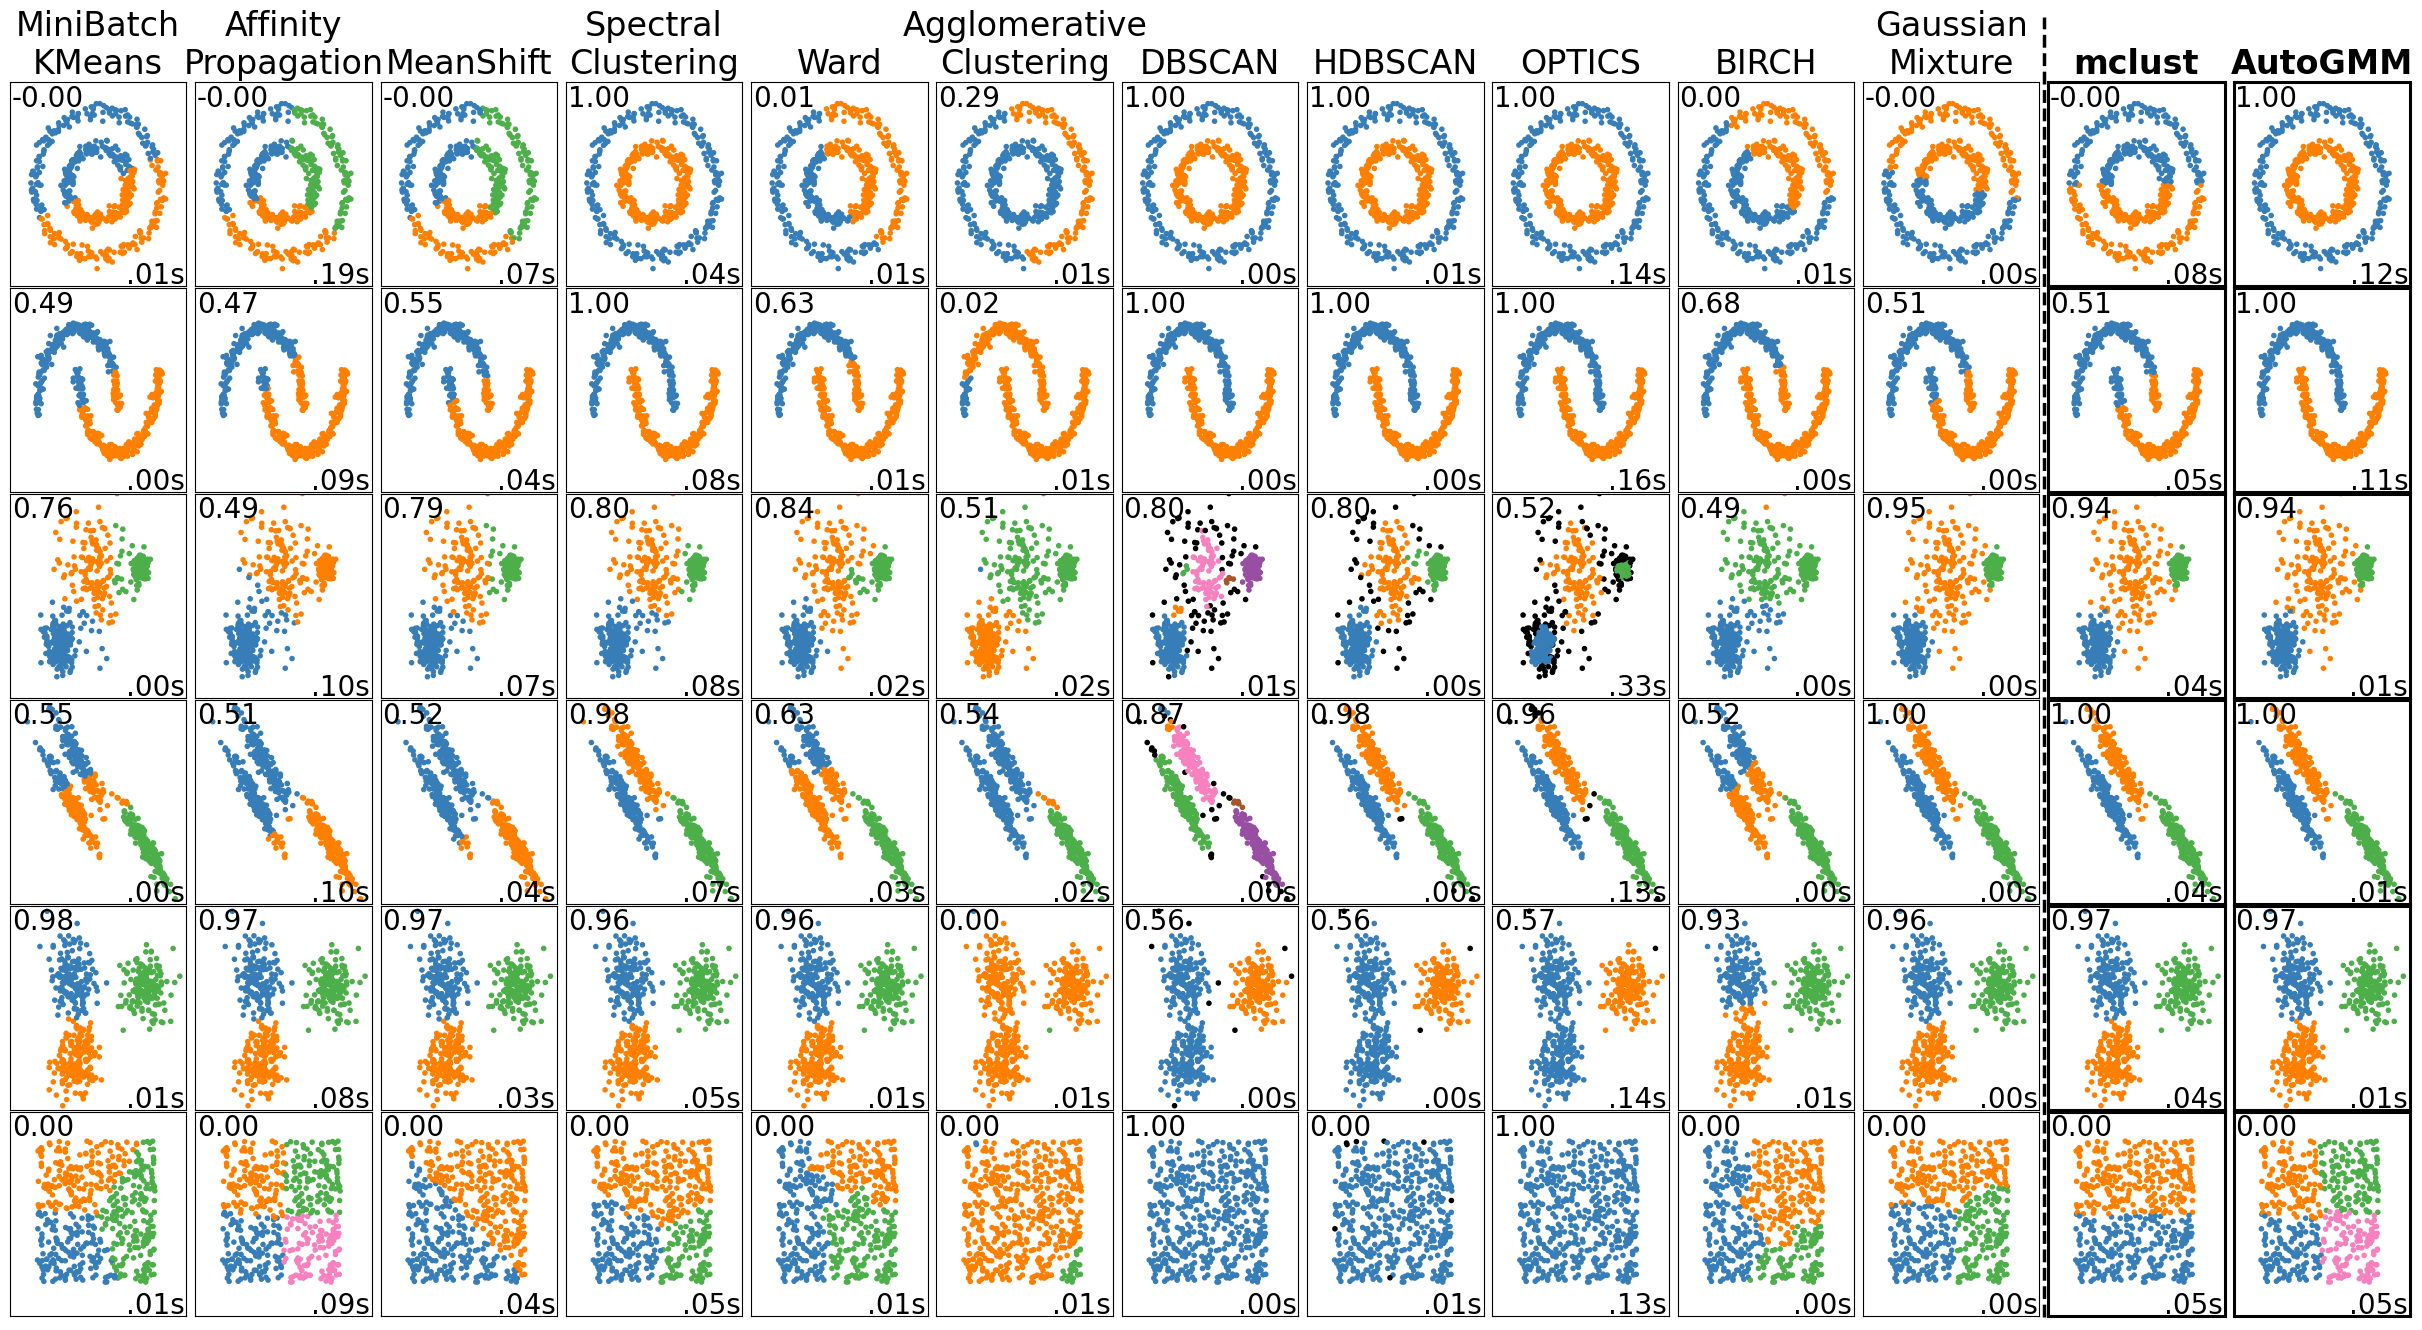

In [11]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(11 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
    "kernel": False
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
            "kernel": True
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
            "kernel": True
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )
    if i_dataset != len(datasets)-1:
        agmm = KernelAutoGMM(min_components=params["n_clusters"], max_components=params["n_clusters"], 
                         n_init_kmeans=0, eigen_thres=True, kernel_embedding=params["kernel"],
                   random_state=params["random_state"], agglom_affinities=['mahalanobis'],
                   agglom_linkages=['ward'], n_jobs=1)
    else:
        agmm = KernelAutoGMM(min_components=1, max_components=5, 
                         n_init_kmeans=0, eigen_thres=True, kernel_embedding=params["kernel"],
                   random_state=params["random_state"], agglom_affinities=['mahalanobis'],
                   agglom_linkages=['ward'], n_jobs=1)
    mc = params["n_clusters"]
    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
        ("mclust", mc),
        ("AutoGMM", agmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            if name != "mclust":
                algorithm.fit(X)
                t1 = time.time()
        
        if name == "mclust":
            if i_dataset != len(datasets)-1:
                y_pred, _, _, _ = run_mclust(X, constrain_cov=False, n_components=mc)
                t1 = time.time()
            else:
                y_pred, _, _, _ = run_mclust(X, constrain_cov=False, n_components=range(1,3))
                t1 = time.time()
            y_pred = y_pred-1
        else:
            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)
        if y is None:
            y = np.zeros((len(X)))
        ari = adjusted_rand_score(y, y_pred)
        # counts = Counter(y_pred)
        # clusters_by_size = [lbl for lbl, _ in counts.most_common()] # sort cluster IDs by descending count
        # remap = {orig_lbl: new_lbl for new_lbl, orig_lbl in enumerate(clusters_by_size)} # uild a remapping: largest→0, 2nd→1, etc.
        # y_pred_ordered = np.array([remap[lbl] for lbl in y_pred])
        # sort cluster labels by their centroid (x then y); keep -1 (noise) as last
        labels = np.unique(y_pred)
        nonnoise = labels[labels != -1]
        centroids = np.array([X[y_pred == lbl].mean(axis=0) for lbl in nonnoise])
        order = np.lexsort((centroids[:, 1], centroids[:, 0]))  # sort by x, then y
        ordered = nonnoise[order]
        remap = {lbl: i for i, lbl in enumerate(ordered)}
        y_pred_ordered = np.array([remap.get(lbl, len(ordered)) for lbl in y_pred], dtype=int)



        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=24)

        colors = np.array(list(islice(cycle([
            # "#984ea3", '#00B8D9', '#FF8F00', '#8D6E63','#00C853', '#00897B',  "#999999","#e41a1c", "#dede00"]), 
            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00"]),
            int(max(y_pred) + 1),)))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=9, color=colors[y_pred_ordered])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=20,
            horizontalalignment="right",
        )
        plt.text(
            0.01,
            0.99,
            "%.2f" % ari,
            transform=plt.gca().transAxes,
            size=20,
            horizontalalignment="left", va='top'
        )
        plot_num += 1

from matplotlib.lines import Line2D

fig = plt.gcf()
axes = fig.axes
# find which column index is the "Gaussian Mixture" plot
gm_idx = next(
    i for i, (name, _) in enumerate(clustering_algorithms)
    if name.replace("\n", "") == "GaussianMixture"
)

# grab the axes positions in figure‐coords
pos_gm   = axes[gm_idx].get_position()      # right edge of GaussianMixture
pos_agmm = axes[gm_idx + 1].get_position()  # left edge of AutoGMM

# place line midway between them
x = 0.5 * (pos_gm.x1 + pos_agmm.x0)

divider = Line2D(
    [x, x], [0, 1],                    # span bottom→top in fig coords
    transform=fig.transFigure,
    color="k", linestyle="--", linewidth=2.5, clip_on=False
)
fig.add_artist(divider)

# --- highlight the right-most algorithms (e.g., 'mclust' and 'AutoGMM') ---
highlight_names = ["mclust", "AutoGMM"]  # <- change if your last columns differ

cols = len(clustering_algorithms)
rows = len(datasets)
name_to_col = {nm.replace("\n", ""): i for i, (nm, _) in enumerate(clustering_algorithms)}
cols_to_highlight = [name_to_col[n] for n in highlight_names]

# subtle tint + thicker colored border for every row in those columns
for r in range(rows):
    for c in cols_to_highlight:
        axh = axes[r*cols + c]
        # axh.set_facecolor("#fff7e6")  # light warm tint
        for sp in axh.spines.values():
            sp.set_linewidth(2.2)
            # sp.set_color("#984ea3")    # accent color

# make the top-row titles bold and colored (and add a star)
for c in cols_to_highlight:
    axt = axes[c]  # row 0 in column c
    axt.set_title(axt.get_title(), size=24, fontweight="bold")



plt.show()

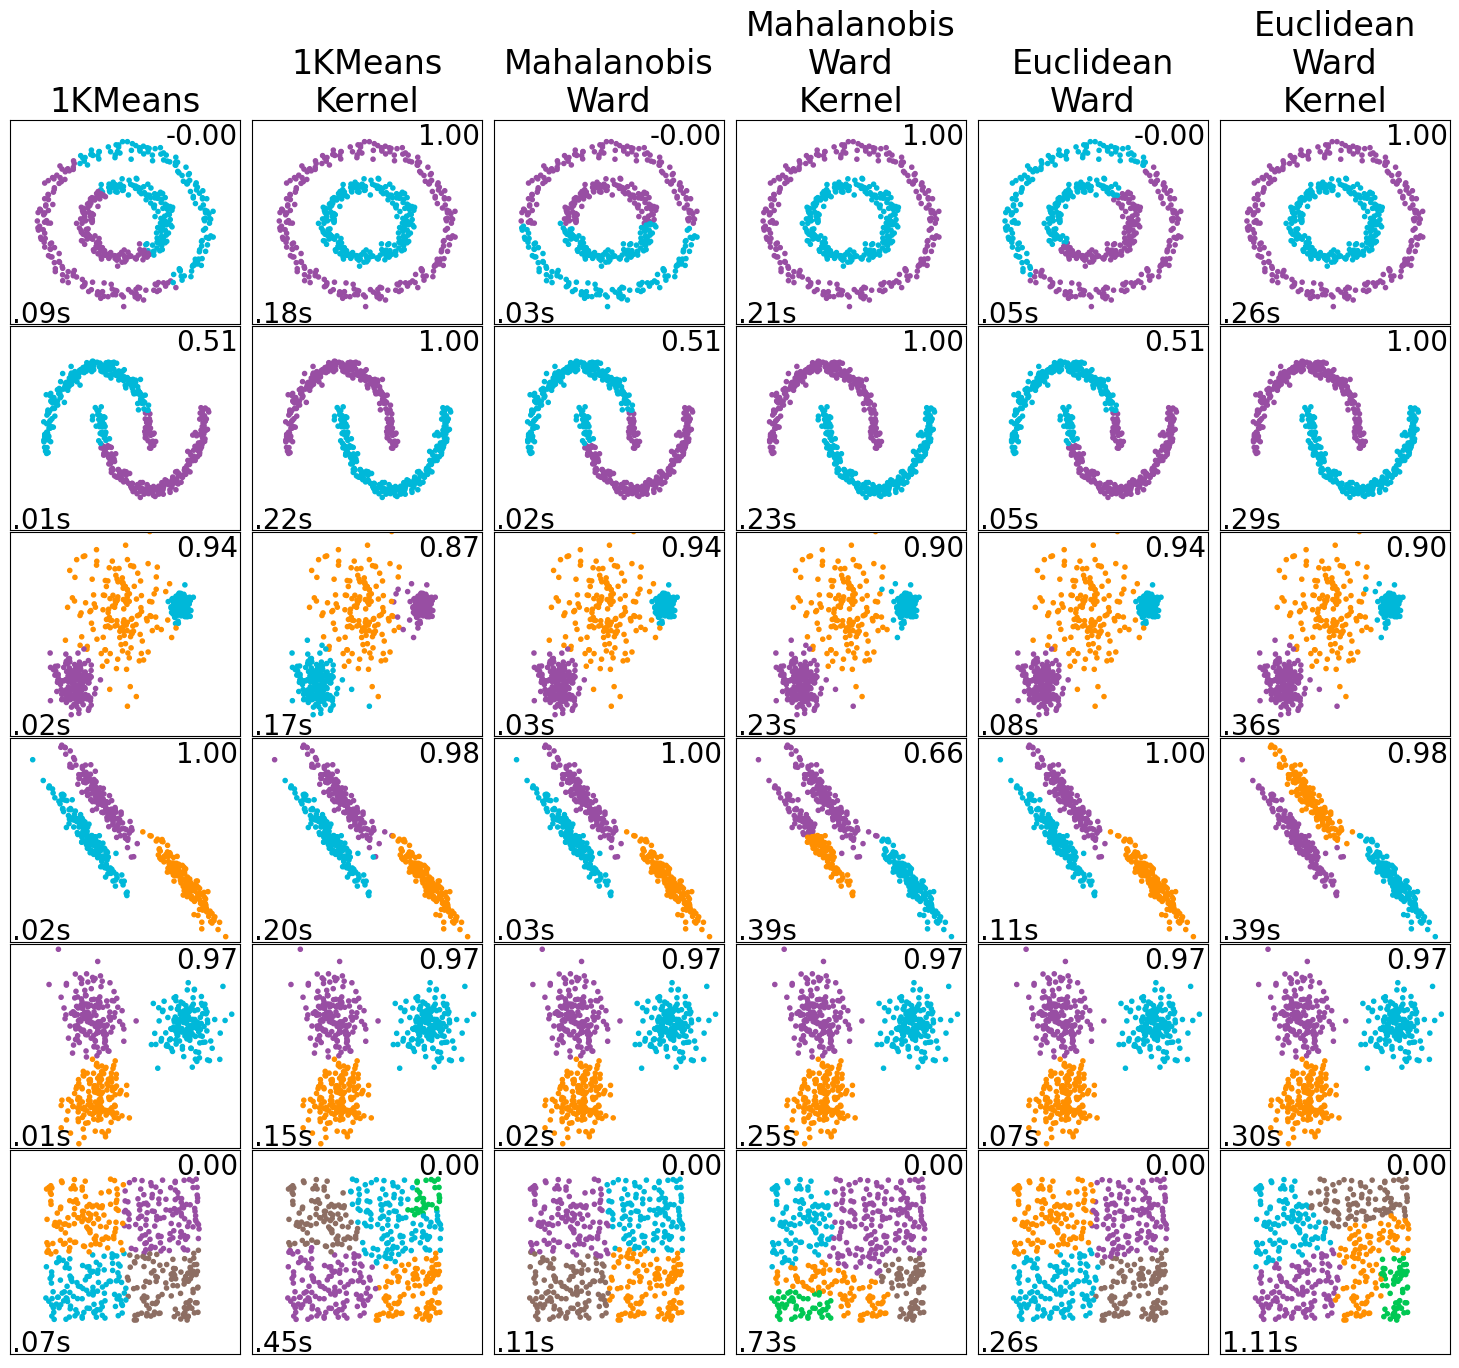

In [ ]:
import time
import warnings
from itertools import cycle, islice

from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler

from collections import Counter

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(6 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1
k1 = [3, 3]; k2 = [2, 2]
# k1 = [1, 5]; k2 = [1, 5]
default_base = {"n_clusters": k1, "random_state": 33}
datasets = [(noisy_circles, {"n_clusters": k2},), (noisy_moons, {"n_clusters": k2},),
    (varied, {},), (aniso, {},), (blobs, {}), (no_structure, {"n_clusters": [1,5],}),]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    agmm_1k = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1], n_init_kmeans=1,
                            init_agglomerative=False, random_state=params["random_state"])
    # agmm_10k = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1], n_init_kmeans=10,
    #                          init_agglomerative=False, random_state=params["random_state"])
    agmm_mah_ward = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1],
                                  agglom_linkages=["ward"], agglom_affinities=["mahalanobis"], n_init_kmeans=0,
                                  random_state=params["random_state"])
    agmm_other_hclust = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1],
                                  agglom_affinities=["euclidean"], n_init_kmeans=0,
                                  random_state=params["random_state"])
    agmm_1k_ker = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1], n_init_kmeans=1,
                            init_agglomerative=False, random_state=params["random_state"], kernel_embedding=True)
    agmm_mah_ward_ker = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1],
                                  agglom_linkages=["ward"], agglom_affinities=["mahalanobis"], n_init_kmeans=0,
                                  random_state=params["random_state"], kernel_embedding=True)
    agmm_other_hclust_ker = KernelAutoGMM(min_components=params["n_clusters"][0], max_components=params["n_clusters"][1],
                                  agglom_affinities=["euclidean"], n_init_kmeans=0,
                                  random_state=params["random_state"], kernel_embedding=True)

    clustering_algorithms = (
        ("1KMeans", agmm_1k),
        ("1KMeans\nKernel", agmm_1k_ker),
        ("Mahalanobis\nWard", agmm_mah_ward),
        ("Mahalanobis\nWard\nKernel", agmm_mah_ward_ker),
        ("Euclidean\nWard", agmm_other_hclust),
        ("Euclidean\nWard\nKernel", agmm_other_hclust_ker),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.perf_counter()
        algorithm.fit(X)
        t1 = time.perf_counter()
        y_pred = algorithm.predict(X)

        counts = Counter(y_pred)
        clusters_by_size = [lbl for lbl, _ in counts.most_common()] # sort cluster IDs by descending count
        remap = {orig_lbl: new_lbl for new_lbl, orig_lbl in enumerate(clusters_by_size)} # uild a remapping: largest→0, 2nd→1, etc.
        y_pred_ordered = np.array([remap[lbl] for lbl in y_pred])
        
        if y is None:
            y = np.zeros((len(X)))
        ari = adjusted_rand_score(y, y_pred)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=24)

        colors = np.array(list(islice(cycle(["#984ea3", '#00B8D9', '#FF8F00', '#8D6E63','#00C853']), int(max(y_pred) + 1),)))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=9, color=colors[y_pred_ordered])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(0.01, 0.01, ("%.2fs" % (t1 - t0)).lstrip("0"), transform=plt.gca().transAxes, size=20, ha="left")
        plt.text(0.99, 0.99, "%.2f" % ari, transform=plt.gca().transAxes, size=20, ha="right", va='top')
        plot_num += 1


plt.show()

In [ ]:
def aniso_plus(seed, rep_id):
    np.random.seed(seed + rep_id)
    cov_1 = 1
    cov_2 = 50
    n = 100
    mu_ = 3
    mu1 = [-mu_, 0]
    mu2 = [mu_, 0]
    cov1 = np.array([[cov_1, 0], [0, cov_2]])
    cov2 = np.array([[cov_1, 0], [0, cov_2]])
    X1 = np.random.multivariate_normal(mu1, cov1, n)
    X2 = np.random.multivariate_normal(mu2, cov2, n)
    X = np.concatenate((X1, X2))
    y = np.repeat([0, 1], int(len(X)/2))

    return X, y

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

def one_rep(seed, rep_id):
    X, y = aniso_plus(seed, rep_id)
    k = len(np.unique(y))
    k1 = k
    k2 = k

    pred = GaussianMixture(n_components=k, random_state=seed+rep_id).fit_predict(X)
    ari_gm = adjusted_rand_score(y, pred)

    pred = AutoGMM(min_components=k1, max_components=k2, random_state=seed+rep_id,
                   n_init_kmeans=0, agglom_affinities=['mahalanobis'], agglom_linkages=['ward']).fit_predict(X)
    ari_mw = adjusted_rand_score(y, pred)

    pred = AutoGMM(min_components=k1, max_components=k2, random_state=seed+rep_id,
                   n_init_kmeans=0, agglom_affinities=['euclidean'], agglom_linkages=['ward']).fit_predict(X)
    ari_ew = adjusted_rand_score(y, pred)

    pred = AutoGMM(min_components=k1, max_components=k2, random_state=seed+rep_id, n_init_kmeans=5, 
                   ).fit_predict(X)
    ari_agmm = adjusted_rand_score(y, pred)

    return ari_gm, ari_mw, ari_ew, ari_agmm


In [68]:
# number of repetitions
n_reps = 50
seed = 0

results = Parallel(n_jobs=-1)(
    delayed(one_rep)(seed, rep_id)
    for rep_id in tqdm(range(n_reps))
)

100%|██████████| 50/50 [00:05<00:00,  8.44it/s]


In [70]:
updated_results = []
for rep_id, (ari1, ari2, ari3, ari4) in enumerate(results):
    X, y = aniso_plus(seed, rep_id)
    k = len(np.unique(y))
    # _, _, _, _, ari8 = run_mclust(pd.DataFrame(X), y_true=y, n_components=range(1,6))
    _, _, _, _, ari5 = run_mclust(X=pd.DataFrame(X), n_components=range(k,k+1), y_true=y, constrain_cov=False)
    updated_results.append((ari1, ari2, ari3, ari4, ari5))

In [ ]:
ari1, ari2, ari3, ari4, ari5= zip(*updated_results)
df = pd.DataFrame({
    'ARI': np.concatenate([ari1, ari3, ari2, ari4, ari5]),
    'Method': (['sklearn GM'] * len(ari1) +
               ['AutoGMM\n(Euc-Ward only)'] * len(ari3) +
               ['AutoGMM\n(Mah-Ward only)'] * len(ari2) +
               ['AutoGMM\n(Full)'] * len(ari4) +
               ['mclust'] * len(ari5))
})
colors = ['#4682B4', '#FA8072', '#B22222', '#8B0000', '#808000']

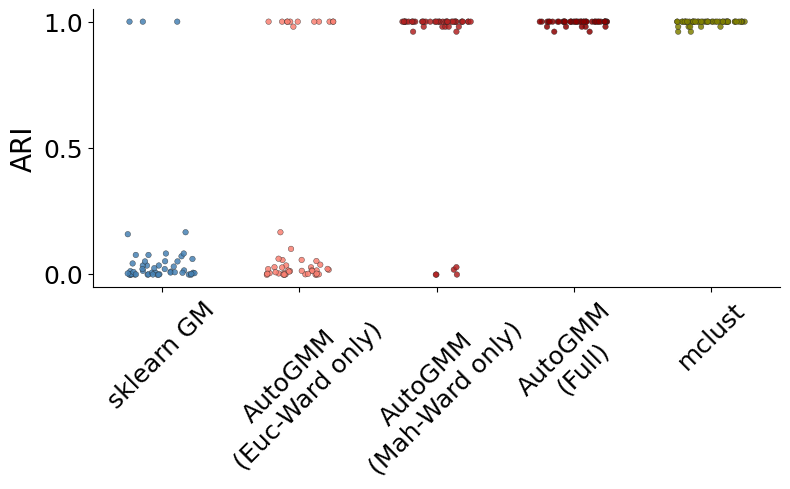

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(len(colors)+3, 5))


sns.stripplot(
    data=df,
    x='Method', y='ARI',
    hue='Method',          # color by method (same as x)
    palette=colors,
    dodge=False,           # don't split since hue==x
    jitter=0.25,           # add jitter
    size=4,
    alpha=0.85,
    linewidth=0.3,
    ax=ax,
)
sns.despine(ax=ax, top=True, right=True)
# Compute mean ARI per method
means = df.groupby('Method')['ARI'].mean()

# Get the plotted category labels in order
labels = [tick.get_text() for tick in ax.get_xticklabels()]


# plt.title('Extreme Variation', fontsize=17)
plt.ylabel('ARI', fontsize=20)
plt.xlabel('')
plt.xticks(rotation=45, ha='center', fontsize=18)
plt.yticks([0,0.5,1], fontsize=18)
# plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
def generate_data(random_state, expand_dim=1, n_samples=500):

    # Anisotropicly distributed data
    X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)

    if expand_dim > 1:
        for idx in range(expand_dim - 1):
            X_, _ = make_blobs(n_samples=n_samples, random_state=idx * random_state)
            X_aniso_ = np.dot(X_, transformation)
            X_aniso = np.concatenate((X_aniso, X_aniso_), axis=1)
    aniso = (X_aniso, y)

    return [aniso]

In [ ]:
def one_rep(expand_dim, seed, rep_id, k1=None, k2=None):
    datasets = generate_data(seed+rep_id, expand_dim)
    aris = []
    for data in datasets:
        X, y = data
        ari = []
        if k1:
            k1_ = k1
            k2_ = k2

        else:
            k1_ = len(np.unique(y))
            k2_ = k1_

        pred = AutoGMM(min_components=k1_, max_components=k2_, n_init_kmeans=1,
                       agglom_affinities=['euclidean', 'mahalanobis'], random_state=seed+rep_id).fit_predict(X)
        ari.append(adjusted_rand_score(y, pred))
      
        aris.append(ari)
    
    return aris


In [33]:
from joblib import Parallel, delayed
from tqdm import tqdm

n_reps = 50
seed = 0
dims = range(1, 11)
k1 = 1
k2 = 5

all_results = []

for dim_ in tqdm(dims):
    results = Parallel(n_jobs=-1)(
        delayed(one_rep)(dim_, seed, rep_id, k1, k2)
        for rep_id in tqdm(range(n_reps))
    )

    updated_results = []
    for rep_id, aris_per_dataset in enumerate(results):
        mclust_arised = []
        datasets = generate_data(seed + rep_id, expand_dim=dim_)
        for dataset_aris, (X, y) in zip(aris_per_dataset, datasets):
            k = len(np.unique(y))
            if k1:
                # _, _, _, _, ari_mclust = run_mclust(X=pd.DataFrame(X), y_true=y, n_components=range(k1, k2+1))
                _, _, _, _, ari_mclust_all = run_mclust(X=pd.DataFrame(X), constrain_cov=False, y_true=y, n_components=range(k1, k2+1))
            else:
                # _, _, _, _, ari_mclust = run_mclust(X=pd.DataFrame(X), y_true=y, n_components=k)
                _, _, _, _, ari_mclust_all = run_mclust(X=pd.DataFrame(X), constrain_cov=False, y_true=y, n_components=k)
            updated = dataset_aris + [ari_mclust_all]
            mclust_arised.append(updated)
        updated_results.append(mclust_arised)

    all_results.append(updated_results)




















100%|██████████| 50/50 [00:09<00:00,  5.42it/s]












100%|██████████| 10/10 [03:45<00:00, 22.53s/it]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def results_to_long_df(all_results, dims, method_names=None, dataset_names=None):
    """
    all_results[dim_idx][rep_idx][dataset_idx][method_idx] -> ARI
    -> DataFrame with columns: Dim, Rep, Dataset, Method, ARI
    """
    first_dim = all_results[0]
    n_datasets   = len(first_dim[0])
    n_methods    = len(first_dim[0][0])

    if method_names is None:
        method_names = ["AutoGMM", "mclust"]
    if dataset_names is None:
        dataset_names = [f"Dataset {i}" for i in range(n_datasets)]

    rows = []
    for dim_val, dim_block in zip(dims, all_results):
        for rep_idx, rep_block in enumerate(dim_block):
            for ds_idx, methods_list in enumerate(rep_block):
                for m_idx, ari in enumerate(methods_list):
                    rows.append({
                        "Dim": int(dim_val),
                        "Rep": int(rep_idx),
                        "Dataset": dataset_names[ds_idx],
                        "Method": method_names[m_idx],
                        "ARI": float(ari),
                    })
    return pd.DataFrame(rows)

# ---- Build df_long ----
df_long = results_to_long_df(all_results, dims,
                             method_names=None, 
                             dataset_names=None) 

dims_even = sorted(df_long["Dim"].unique())
df_long["Dim"] = pd.Categorical(df_long["Dim"], categories=dims_even, ordered=True)
df_long["Dim_num"] = df_long["Dim"].astype(int)


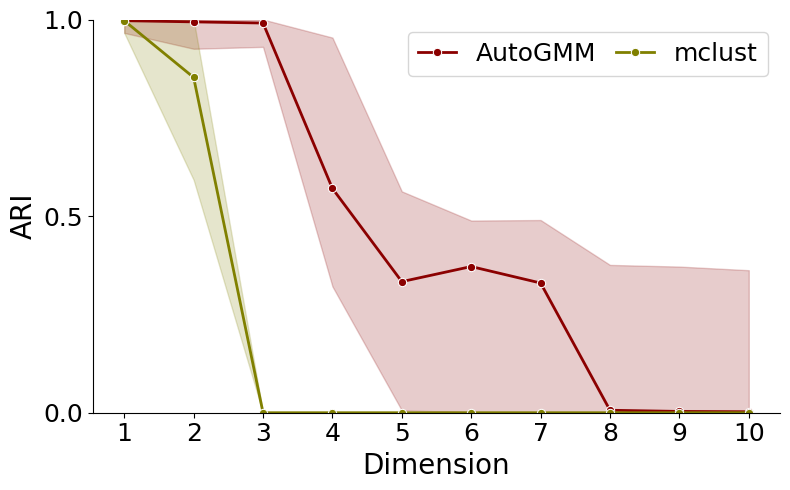

In [60]:
plt.figure(figsize=(8, 5))
colors = ["#8B0000", "#808000"]

ax = sns.lineplot(
    data=df_long,
    x="Dim_num", y="ARI", hue="Method",
    palette=colors,
    estimator=np.median,
    errorbar=("pi", 50),
    marker="o", linewidth=2
)

sns.despine(ax=ax, top=True, right=True)
plt.ylabel('ARI', fontsize=20)
plt.xticks(rotation=0, ha='center', fontsize=18)
plt.yticks([0,0.5,1], fontsize=18)

ax.set_ylim(0, 1)
ax.set_xlabel("Dimension", fontsize=20)
ax.set_xticks(dims_even)
ax.legend(title=None, ncol=3, fontsize=18, handlelength=1.5, columnspacing=0.8)
plt.tight_layout()
plt.show()

### real data

In [41]:
frag_df = pd.read_csv('fragmentomics_data_for_AutoGMM_JMLR.csv')
protein_df = pd.read_csv('proteomics_data_for_AutoGMM_JMLR.csv')

In [42]:
frag_df = frag_df[frag_df['Cohort'] != 1]
frag_pc = frag_df.loc[:, frag_df.columns.str.startswith("PC")].to_numpy()
frag_label = frag_df['Cohort'].values
print(frag_pc.shape, frag_label.shape)

(466, 12) (466,)


In [43]:
protein_var = protein_df.loc[:, protein_df.columns.str.startswith("Protein")].to_numpy()
protein_label = protein_df['Cohort'].values
print(protein_var.shape, protein_label.shape)

(709, 17) (709,)


In [44]:
droso_embed = np.genfromtxt('data/embedded_right.csv', delimiter=',', skip_header=1)
droso_df = pd.read_csv('data/embedded_right.csv')
droso_true = np.genfromtxt('data/classes.csv', skip_header=1)
print(droso_embed.shape)

(213, 6)


In [45]:
from scipy.spatial.distance import pdist, squareform
from ase import AdjacencySpectralEmbed
from scipy.stats import rankdata

In [63]:
X = frag_pc.copy()
# Compute squared Euclidean distance matrix
distance_matrix = squareform(pdist(X, metric='sqeuclidean'))
# distance_matrix = squareform(pdist(merged_features, metric='sqeuclidean'))
ranked_distance_matrix = rankdata(distance_matrix, axis=None).reshape(distance_matrix.shape)

In [64]:
# # Perform Adjacency Spectral Embedding
# # for drosophila
# ase_ = AdjacencySpectralEmbed(n_elbows=3)
# ase_transform = ase_.fit_transform(distance_matrix)

# for fragmentomics
ase_ = AdjacencySpectralEmbed(n_elbows=2)
ase_transform = ase_.fit_transform(ranked_distance_matrix)

loadings = ase_.latent_left_
ase_transform.shape[1]

3

In [66]:
k1_, k2_ = 1, 5
y = frag_label.copy()
agmm = AutoGMM(min_components=k1_, max_components=k2_, agglom_linkages=['ward'], agglom_affinities=['mahalanobis'], random_state=0, n_jobs=-1)
pred_agmm = agmm.fit_predict(X)
print(adjusted_rand_score(y, pred_agmm), len(np.unique(pred_agmm)))

pred_mc, _, _, _, ari_ = run_mclust(X, n_components=range(k1_, k2_+1), constrain_cov=False, y_true=y)
print(ari_, len(np.unique(pred_mc)))

0.2985659297817876 4
0.24705710438153186 3


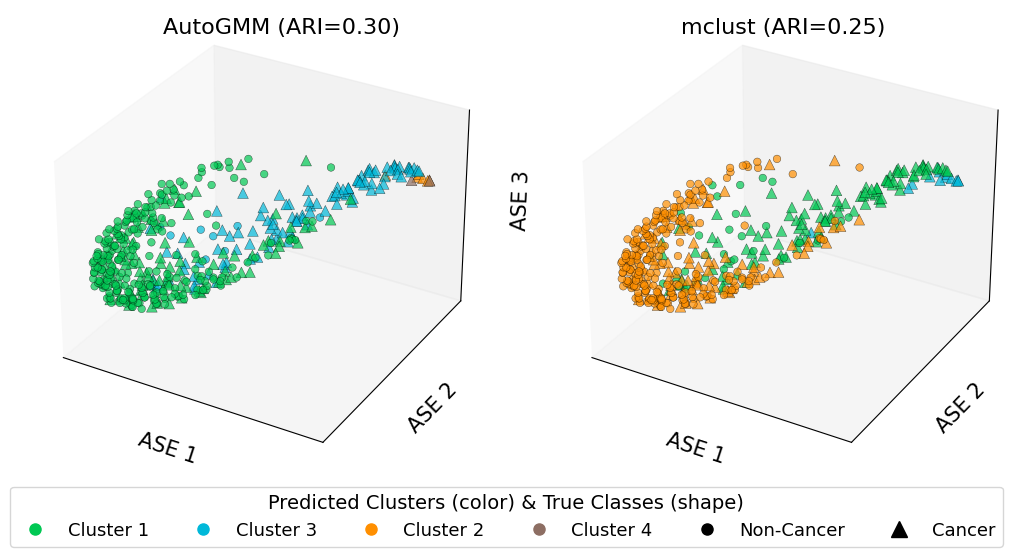

In [73]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines

df = pd.DataFrame({"ASE_1": ase_transform[:,0], "ASE_2": ase_transform[:,1], "ASE_3": ase_transform[:,2],
    "pred_agmm": pred_agmm, "pred_mc": pred_mc-1, "true": y})

# clusters = np.unique(df["pred_agmm"])
clusters = df["pred_agmm"].value_counts().index.to_numpy()
cluster_to_idx = {int(cl): i for i, cl in enumerate(clusters)}

true_classes = range(len(np.unique(df["true"]))+1)
# colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]
colors = ['#00C853',  '#00B8D9',  '#FF8F00',  '#8D6E63',  '#00897B']

markers = {true_classes[0]: "o", true_classes[2]: "^", true_classes[1]: "s"}

fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
plt.subplots_adjust(wspace=-0.05)
label_cols = ["pred_agmm", "pred_mc"]
titles = ["AutoGMM (ARI=0.30)", "mclust (ARI=0.25)"]

for ax, label_col, title in zip(axes, label_cols, titles):
    for t in true_classes:
        for c in clusters:
            sub = df[(df["true"] == t) & (df[label_col] == c)]
            if sub.empty:
                continue
            # enlarge triangle markers
            size = 30 if markers[t] != "^" else 60
            ax.scatter(sub["ASE_1"], sub["ASE_2"], sub["ASE_3"], c=colors[cluster_to_idx[int(c)] % len(colors)],
                marker=markers[t], s=size, alpha=0.7, edgecolor='k', linewidth=0.3)
    # ax.set_title(title, fontsize=16, pad=-1)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel("ASE 1", fontsize=15); ax.set_ylabel("ASE 2", fontsize=15); ax.set_zlabel("ASE 3", fontsize=15)

cluster_handles = [mlines.Line2D([], [], color=colors[cluster_to_idx[int(c)] % len(colors)],
                  marker='o', linestyle='None', markersize=8,
                  label=f"Cluster {c+1}") for c in clusters]
true_classes_names = ['Non-Cancer', 'Cancer']
markers = ['o', '^']
true_handles = [mlines.Line2D([], [], color='k', marker=markers[i], linestyle='None', 
                markersize=8 if markers[t]=="o" else 12, label=f"{true_classes_names[i]}") for i,t in enumerate(true_classes[:-1])]
fig.text(0.255, 0.84, 'AutoGMM (ARI=0.30)', fontsize=16)
fig.text(0.625, 0.84, 'mclust (ARI=0.25)', fontsize=16)
fig.legend(handles=cluster_handles + true_handles, loc='upper center', ncol=8, bbox_to_anchor=[0.5, 0.1],
           title="Predicted Clusters (color) & True Classes (shape)", fontsize=13, title_fontsize=14)

plt.show()


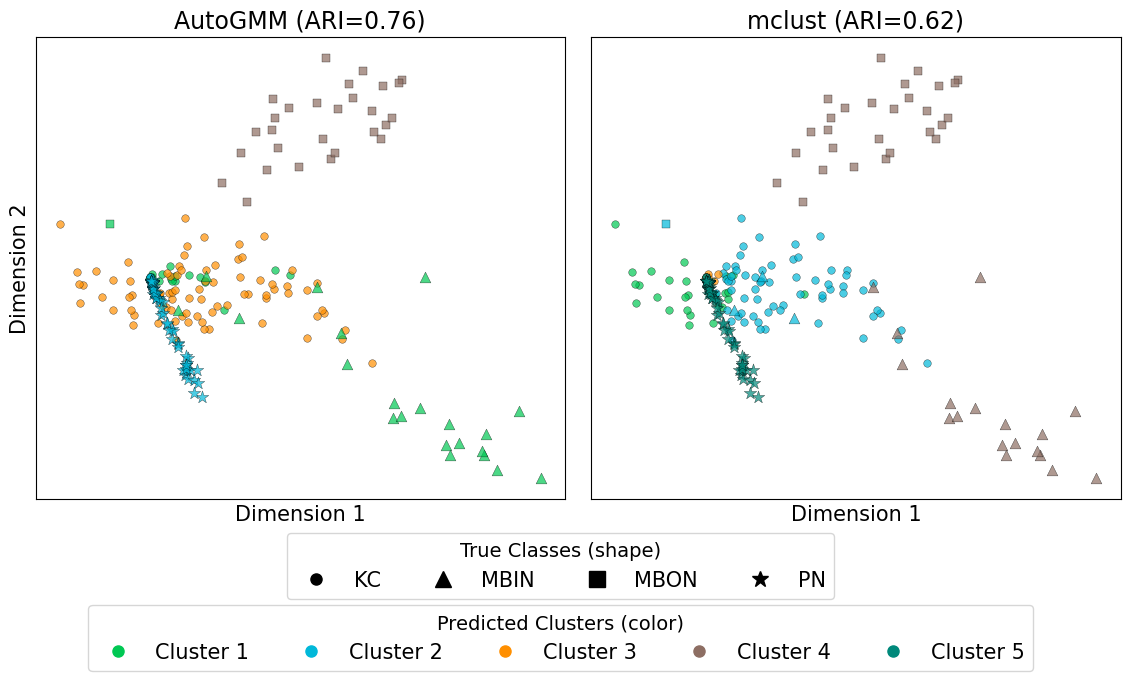

In [62]:
df = pd.DataFrame({"ASE_1": ase_transform[:,3], "ASE_2": ase_transform[:,4],
    "pred_agmm": pred_agmm, "pred_mc": pred_mc-1, "true": y-1})

clusters = range(max(len(np.unique(df["pred_agmm"])), len(np.unique(df["pred_mc"])))+1)
true_classes = np.unique(df["true"])
# colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#984ea3", "#a65628", "#999999", "#e41a1c", "#dede00"]
colors = ['#00C853',  '#00B8D9',  '#FF8F00',  '#8D6E63',  '#00897B']
markers = {true_classes[0]: "o", true_classes[1]: "^", true_classes[2]: "s", true_classes[3]: "*"}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.05)
label_cols = ["pred_agmm", "pred_mc"]
titles = ["AutoGMM", "mclust"]

for ax, label_col, title in zip(axes, label_cols, titles):
    for t in true_classes:
        for c in clusters:
            sub = df[(df["true"] == t) & (df[label_col] == c)]
            if sub.empty:
                continue
            # enlarge triangle markers
            size = {'o': 30, '*': 90, 's': 40}.get(markers[t], 60)
            ax.scatter(sub["ASE_1"], sub["ASE_2"], c=colors[int(c) % len(colors)],
                marker=markers[t], s=size, alpha=0.7, edgecolor='k', linewidth=0.3)
    ax.set_title(title, fontsize=17)
    ax.set_xticks([]); ax.set_yticks([])
    if title == 'AutoGMM':
        ax.set_title("AutoGMM (ARI=0.76)", fontsize=17)
        ax.set_ylabel("Dimension 2", fontsize=15)
    else:
        ax.set_title("mclust (ARI=0.62)", fontsize=17)
    ax.set_xlabel("Dimension 1", fontsize=15)

cluster_handles = [mlines.Line2D([], [], color=colors[int(c)%len(colors)], marker='o', linestyle='None', markersize=8,
                  label=f"Cluster {c+1}") for c in clusters[:-1]]
true_classes_names = ['KC', 'MBIN', 'MBON', 'PN']
true_handles = [mlines.Line2D([], [], color='k', marker=markers[t], linestyle='None', 
                markersize=8 if markers[t]=="o" else 12, label=f"{true_classes_names[i]}") for i,t in enumerate(true_classes)]

fig.legend(handles=true_handles, loc='upper center', ncol=9, bbox_to_anchor=[0.5, 0.07], 
           title="True Classes (shape)", fontsize=15, title_fontsize=14)
fig.legend(handles=cluster_handles, loc='upper center', ncol=9, bbox_to_anchor=[0.5, -0.05], 
           title="Predicted Clusters (color)", fontsize=15, title_fontsize=14)

plt.show()
